Resumen:
    
En  este notebook hemos probado los siguientes modelos de detección de outliers con métodos no supervisados y comparado los resultados con los outliers marcados en el dataset provisto. 

Los siguientes modelos fueron probados con diferentes hiperparámetros y se escogió el óptimo en función de la detección de outliers

    Outlier Detector
    Quantile AD
    Autoregression AD
    Volatility Shift
    min_cluster_detector
 
    
    
El modelo que mejor ajusta a los outliers marcados es Quantile AD con las siguientes métricas

    Precision                                   : 0.894
    Recall                                      : 0.857
    F1-Score                                    : 0.875
    
Más abajo se documentan los experimentos realizados



## Set Up

In [96]:
import pandas as pd

print(f"{'pandas':<11} {pd.__version__:<6}")

import numpy as np

print(f"{'numpy':<11} {np.__version__:<6}")

import plotly

print(f"{'plotly':<11} {pd.__version__:<6}")

import matplotlib
import matplotlib.pyplot as plt
print(f"{'matplotlib':<11} {matplotlib.__version__:<6}")

import itertools

from adtk import __version__ as adtk_version

print(f"{'adtk':<11} {adtk_version:<6}")

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import QuantileAD
from adtk.detector import InterQuartileRangeAD
from adtk.detector import PersistAD
from adtk.detector import LevelShiftAD
from adtk.detector import VolatilityShiftAD
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD
from adtk.detector import MinClusterDetector
from adtk.detector import OutlierDetector
from adtk.detector import PcaAD
from adtk.detector import GeneralizedESDTestAD

from adtk.data import validate_series
from adtk.visualization import plot

from sklearn import __version__ as sklearn_version

print(f"{'sklearn':<11} {sklearn_version:<6}")
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans

#from io import StringIO
#from support.convertion import load_conversion_from
#from support.parsers import p2f
#from support.parsers import d2d
from datetime import datetime, timedelta
from typing import List, Dict

# plt.rcParams["figure.figsize"] = [14, 10]
# plt.style.use("ggplot")

%matplotlib inline
%load_ext autoreload
%autoreload 2

pandas      1.1.3 
numpy       1.19.2
plotly      1.1.3 
matplotlib  3.3.2 
adtk        0.6.2 
sklearn     0.23.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
file_path ="https://raw.githubusercontent.com/feliperichard/TP3/main/TP3_Intro_a_ML/datasets/traffic_AR_CL_UY%2Bfeatures%2Bcolumn_classifier.csv"
df0: pd.DataFrame = pd.read_csv(
    file_path,
    parse_dates=["Fecha"]
)
df0["Fecha"] = pd.to_datetime(df0["Fecha"], utc=True)


<AxesSubplot:title={'center':'Dist'}>

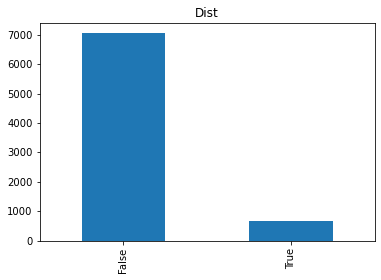

In [98]:
df0["anomaly"].value_counts().plot(kind='bar', 
                                     title='Dist')

In [99]:
import plotly.graph_objects as go


def anomaly_plot(
    ts=None, anomaly=None, anomaly_color: str = "red", mode: str = "markers", title=""
):

    df: pd.DataFrame = None
    anomalies: pd.DataFrame = None

    if ts is not None:
        # type check for ts
        if isinstance(ts, pd.Series):
            if ts.name is None:
                df = ts.to_frame("Time Series")
            else:
                df = ts.to_frame()
        elif isinstance(ts, pd.DataFrame):
            df = ts.copy()
        else:
            raise TypeError("Argument `ts` must be a pandas Series or DataFrame.")

        # check series index
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(
                "Index of the input time series must be a pandas "
                "DatetimeIndex object."
            )

        # check duplicated column names
        if df.columns.duplicated().any():
            raise ValueError("Input DataFrame must have unique column names.")

    else:  # no time series, just event
        df = pd.DataFrame(dtype=int)

    # plot anomaly
    if anomaly is not None:
        pass
    else:
        raise ValueError("Anomaly values should be provided")

    if isinstance(anomaly, pd.Series):

        anomaly: pd.Series = anomaly
        idx: pd.DatetimeIndex = anomaly[anomaly == True].index

        if anomaly.name in df.columns:
            anomalies: pd.DataFrame = df.loc[idx][anomaly.name].to_frame()
        else:
            anomalies: pd.DataFrame = df.loc[idx]
    elif isinstance(anomaly, pd.DataFrame):
        anomaly: pd.DataFrame = anomaly
        anomalies: pd.DataFrame = pd.DataFrame(columns=df.columns)
        for anomaly_name in anomaly.columns:
            if anomaly_name in df.columns:
                anomalies = pd.concat(anomalies, df.loc[anomaly[anomaly_name] == True])

    fig = go.Figure()

    for column_name in df.columns:
        # Add scatter trace for line
        fig.add_trace(
            go.Scatter(x=df.index, y=df[column_name], mode="lines", name=column_name)
        )
    for column_name in anomalies.columns:
        fig.add_trace(
            go.Scatter(
                x=anomalies.index,
                y=anomalies[column_name],
                mode="markers",
                marker=dict(
                    color="LightSkyBlue",
                    size=6,
                    opacity=0.5,
                    line=dict(color="red", width=2),
                ),
                showlegend=False,
            ),
        )
    fig.update_layout(
        title={"text": title,}
    )
    fig.show()

In [100]:
# Model Evaluation
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot( Y_test, Y_preds ):

    conf_mat = confusion_matrix(Y_test, Y_preds)
    print(conf_mat)
    with plt.style.context(('ggplot', 'seaborn')):
        fig = plt.figure(figsize=(6,6), num=1)
        plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
        plt.xticks([0,1],[0,1])
        plt.yticks([0,1],[0,1])
        plt.xlabel('Predicted Label')
        plt.ylabel('Actual Label')
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                    plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
        plt.grid(None)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.show()



In [101]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

def print_report( Y_test, Y_preds ):
    print('Precision                                   : %.3f'%precision_score(Y_test, Y_preds))
    print('Recall                                      : %.3f'%recall_score(Y_test, Y_preds))
    print('F1-Score                                    : %.3f'%f1_score(Y_test, Y_preds))
    print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(Y_test, Y_preds))
    print('\nClassification Report                       : ')
    print(classification_report(Y_test, Y_preds))

Elegimos un el site MLA, Flow Direct y Device Desktop para hacer el análisis


In [102]:
#sites = list(df0["Site"].unique())
#flows= list(df0["flow"].unique())
#devices= list(df0["Device"].unique())

sites=["MLA"]
flows=["direct"]
devices=["Desktop"]

#sites: List[str] = list(df0["Site"].unique())
#flows: List[str] = list(df0["flow"].unique())
#devices: List[str] = list(df0["Device"].unique())
    
criteria = [
    (site, flow, device) for site in sites for flow in flows for device in devices
]

for (site, flow, device) in criteria:
     #print(f"⚪ Finding missing dates for  '({site},{flow})' on '{device}' ")
    print(site)
    print(flow)
    print(device)
    
    result: pd.DataFrame = df0.query(
        f""" Site == "{site}" and flow == '{flow}' and Device == '{device}' """
    )
    if len(result.index) < 1:
        # print(f"🟢 No value found on '{site}' and flow '{flow}'\n")
        continue
        
    serie = result.set_index(["Fecha"])
    # Usaremos la conversion total como input
    s = serie["TOTAL"]
    s = validate_series(s)

    #quantile_ad = QuantileAD(high=0.97, low=0.03)
    #qad_anomalies = quantile_ad.fit_detect(s)
    #anomaly_plot(
    #     s,
    #     anomaly=qad_anomalies,
    #     anomaly_color="red",
    #     title=f" QuantileAD Plot for site {site} on flow {flow} and device {device}",
    #)
       
    # volatility_shift_ad = VolatilityShiftAD(c=2.5, side="both", window=14)
    # anomalies = volatility_shift_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    # try:
    #    level_shift_ad = LevelShiftAD(c=3.0, side='both', window=14)
    #    sad_anomalies = level_shift_ad.fit_detect(s)
    #    anomaly_plot(
    #       s,
    #       anomaly=sad_anomalies,
    #       anomaly_color="red",
    #       title=f" Shift Anomaly Plot for site {site} on flow {flow} and device {device}",
    #   )   
    # except:
    #     print("An exception occurred")
    
    # esd_ad = GeneralizedESDTestAD(alpha=0.05)
    # esd_anomalies = esd_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=esd_anomalies, anomaly_color="red")

    # autoregression_ad = AutoregressionAD(n_steps=7 * 2, step_size=3, c=3.0)
    # anomalies = autoregression_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    #outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.17))
    # outlier_detector = OutlierDetector(IsolationForest(contamination=0.35))
    # outlier_detector = OutlierDetector(EllipticEnvelope(contamination=0.23))

    #od_anomalies = outlier_detector.fit_detect(s.to_frame())
    #anomaly_plot(
    #    s,
    #    anomaly=od_anomalies,
    #    anomaly_color="red",
    #    title=f" OutlierDetector Plot for site {site} on flow {flow} and device {device}",
    #)
    
    #min_cluster_detector = MinClusterDetector(KMeans(n_clusters=8))
    #anomalies = min_cluster_detector.fit_detect(s.to_frame())
   
     
    #anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    # seasonal_ad = SeasonalAD(c=3.0, side="both")
    # anomalies = seasonal_ad.fit_detect(s)
    # anomaly_plot(s, anomaly=anomalies, anomaly_color="red")

    
    #Y_test = serie["anomaly"]
    #Y_preds = od_anomalies

    #confusion_matrix_plot(Y_test, Y_preds)
    #print_report(Y_test, Y_preds)

MLA
direct
Desktop


In [103]:
from numpy.random import randint

Results_OD = pd.DataFrame(columns=['Parametro', 'Recall', 'Precision'])
Results_OD.set_index('Parametro')


,Recall,Precision
Parametro,,


Probamos el Modelo Outlier Detector con varios parámetros de Contaminación e imprimimos Precision y Recall para ver los resultados.

In [104]:
#Outlier Detector: encontrar el mejor parametro de contaminación

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.1))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
Y_test = serie["anomaly"]
Y_preds = od_anomalies
new_row = {'Parametro':'Contamination 0.1', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_OD = Results_OD.append(new_row, ignore_index=True)


outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.15))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
Y_test = serie["anomaly"]
Y_preds = od_anomalies
new_row = {'Parametro':'Contamination 0.15', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_OD = Results_OD.append(new_row, ignore_index=True)

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.20))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
Y_test = serie["anomaly"]
Y_preds = od_anomalies
new_row = {'Parametro':'Contamination 0.2', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_OD = Results_OD.append(new_row, ignore_index=True)

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.25))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
Y_test = serie["anomaly"]
Y_preds = od_anomalies
new_row = {'Parametro':'Contamination 0.25', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_OD = Results_OD.append(new_row, ignore_index=True)

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.30))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
Y_test = serie["anomaly"]
Y_preds = od_anomalies
new_row = {'Parametro':'Contamination 0.30', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_OD = Results_OD.append(new_row, ignore_index=True)

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.35))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
Y_test = serie["anomaly"]
Y_preds = od_anomalies
new_row = {'Parametro':'Contamination 0.35', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_OD = Results_OD.append(new_row, ignore_index=True)



Como puede verse más abajo, para niveles bajos de contaminación los niveles de Recall son bajos y el modelo alcanza mayores niveles de precisión. Al subir los niveles de contaminanción (mayor cantidad de casos serán determinados como outliers), la métrica recall va mejorando y la precisión va empeorando.

Notamos que el Recall mejora signifcativamente al pasar de 0.15 a 0.20 el contamination y el precision se mantiene constante. A partir de ese punto (0.25 en adelante) las bajas en Precision son significativas y el recall no mejora demasiado.


<AxesSubplot:xlabel='Parametro'>

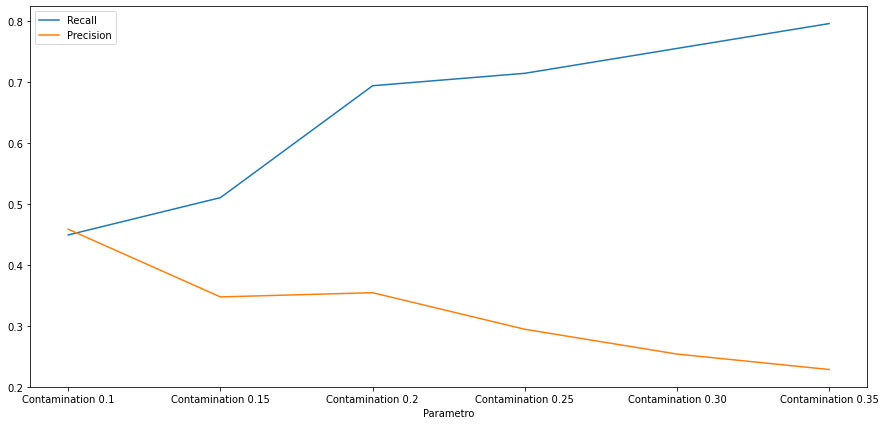

In [105]:
Results_OD.plot(x="Parametro",figsize = (15, 7))

[[377  62]
 [ 15  34]]


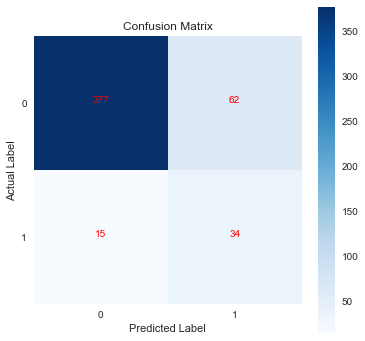

Precision                                   : 0.354
Recall                                      : 0.694
F1-Score                                    : 0.469

Precision Recall F1-Score Support Per Class : 
 (array([0.96173469, 0.35416667]), array([0.85876993, 0.69387755]), array([0.90734055, 0.46896552]), array([439,  49], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.96      0.86      0.91       439
        True       0.35      0.69      0.47        49

    accuracy                           0.84       488
   macro avg       0.66      0.78      0.69       488
weighted avg       0.90      0.84      0.86       488



In [106]:
#Outlier Detector
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.20))
od_anomalies = outlier_detector.fit_detect(s.to_frame())
anomaly_plot(
s,
anomaly=od_anomalies,
anomaly_color="red",
title=f" OutlierDetector Plot for site {site} on flow {flow} and device {device} Contamination 0.3",
)
    
Y_test = serie["anomaly"]
Y_preds = od_anomalies

confusion_matrix_plot(Y_test, Y_preds)
print_report(Y_test, Y_preds) 

Ahora vamos a utilizar el modelo Quantile_Ad que lo que hace es determinar como outliers aquellos puntos que estan por encima o debajo del Quantile pasado como parpametro.

A continuación ejecutamos el modelo con varios parámetros para ver cual tiene mejor perfomance

In [107]:
Results_Quantile = pd.DataFrame(columns=['Parametro', 'Recall', 'Precision'])
Results_Quantile.set_index('Parametro')


,Recall,Precision
Parametro,,


In [108]:
#Eleccion de parametros para Quantile Ad

quantile_ad = QuantileAD(high=0.90, low=0.10)
qad_anomalies = quantile_ad.fit_detect(s)
Y_test = serie["anomaly"]
Y_preds = qad_anomalies
new_row = {'Parametro':'high=0.90, low=0.10', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_Quantile = Results_Quantile.append(new_row, ignore_index=True)

quantile_ad = QuantileAD(high=0.93, low=0.07)
qad_anomalies = quantile_ad.fit_detect(s)
Y_test = serie["anomaly"]
Y_preds = qad_anomalies
new_row = {'Parametro':'high=0.93, low=0.07', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_Quantile = Results_Quantile.append(new_row, ignore_index=True)


quantile_ad = QuantileAD(high=0.95, low=0.05)
qad_anomalies = quantile_ad.fit_detect(s)
Y_test = serie["anomaly"]
Y_preds = qad_anomalies
new_row = {'Parametro':'high=0.95, low=0.05', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_Quantile = Results_Quantile.append(new_row, ignore_index=True)

quantile_ad = QuantileAD(high=0.97, low=0.03)
qad_anomalies = quantile_ad.fit_detect(s)
Y_test = serie["anomaly"]
Y_preds = qad_anomalies
new_row = {'Parametro':'high=0.97, low=0.03', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_Quantile = Results_Quantile.append(new_row, ignore_index=True)


quantile_ad = QuantileAD(high=0.99, low=0.01)
qad_anomalies = quantile_ad.fit_detect(s)
Y_test = serie["anomaly"]
Y_preds = qad_anomalies
new_row = {'Parametro':'high=0.99, low=0.01', 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
Results_Quantile = Results_Quantile.append(new_row, ignore_index=True)


Como puede verse abajo, a medida que subimos los quantiles la precisión mejora y el recall empeora. En otras palabras, si nos ponemos más restrictivos para considerar un punto como outlier nos aseguramos de que los outliers detectados realmente lo sean. Sin embargo, el costo es que muchos puntos que son outliers no son detectados por el modelo.

A partir del parámetro High = 0.95% , Low = 0.05% podemos ver que el recall empeora significativamente pero la ganancia por precisión no es muy singnificativa. Por esa razón elegimos estos hiperparámetros

<AxesSubplot:xlabel='Parametro'>

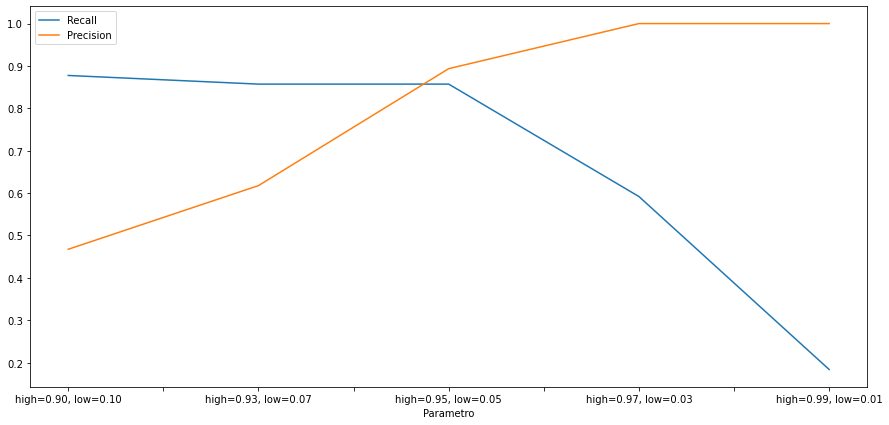

In [109]:
Results_Quantile.plot(x="Parametro",figsize = (15, 7))


Abajo pueden verse los puntos detecatdos como outliers y los resultados de las metricas.

[[434   5]
 [  7  42]]


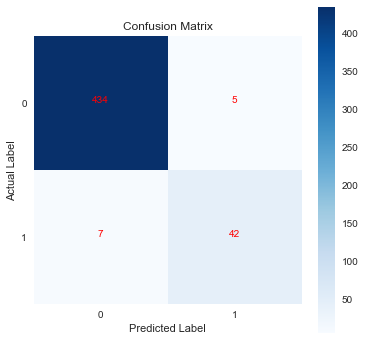

Precision                                   : 0.894
Recall                                      : 0.857
F1-Score                                    : 0.875

Precision Recall F1-Score Support Per Class : 
 (array([0.98412698, 0.89361702]), array([0.98861048, 0.85714286]), array([0.98636364, 0.875     ]), array([439,  49], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.98      0.99      0.99       439
        True       0.89      0.86      0.88        49

    accuracy                           0.98       488
   macro avg       0.94      0.92      0.93       488
weighted avg       0.98      0.98      0.98       488



In [110]:
#quantile_ad
quantile_ad = QuantileAD(high=0.95, low=0.05)
qad_anomalies = quantile_ad.fit_detect(s)
anomaly_plot(
s,
anomaly=qad_anomalies,
anomaly_color="red",
title=f" QuantileAD Plot for site {site} on flow {flow} and device {device}",
)
    
Y_test = serie["anomaly"]
Y_preds = qad_anomalies

confusion_matrix_plot(Y_test, Y_preds)
print_report(Y_test, Y_preds) 
    

Autoregresssion_AD detecta cambios anómalos en la regresión. Lo probamos con varios hiperparámetros pero no logramos detectar una cantidad significativa de outliers

[[439   0]
 [ 47   2]]


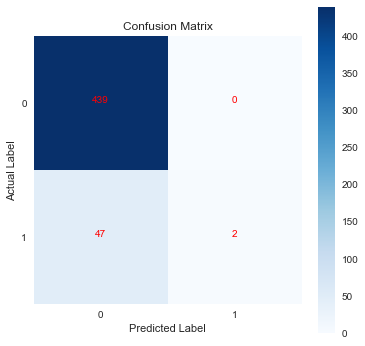

Precision                                   : 1.000
Recall                                      : 0.041
F1-Score                                    : 0.078

Precision Recall F1-Score Support Per Class : 
 (array([0.90329218, 1.        ]), array([1.        , 0.04081633]), array([0.94918919, 0.07843137]), array([439,  49], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.90      1.00      0.95       439
        True       1.00      0.04      0.08        49

    accuracy                           0.90       488
   macro avg       0.95      0.52      0.51       488
weighted avg       0.91      0.90      0.86       488



In [111]:
#Autoregression
autoregression_ad = AutoregressionAD(n_steps=7 * 2, step_size=2, c=10.0)
anomalies_ad = autoregression_ad.fit_detect(s)
anomaly_plot(s, anomaly=anomalies_ad, anomaly_color="red",
title=f" Autoregression Plot for site {site} on flow {flow} and device {device}"
)
    
Y_test = serie["anomaly"]
Y_preds = anomalies_ad
Y_preds=np.nan_to_num(Y_preds) #convierte NaN en zeros
confusion_matrix_plot(Y_test, Y_preds)
print_report(Y_test, Y_preds) 


Volatility Shift detecta cambios en la volatilidad en la serie analizando las variaciones en una ventana de tiempo. En nuestros caso, no cumple el objetivo de detectar una cantidad significativa de outliers.

Sin embargo este modelo es útil para detectar mayores cambios en volatilidad

In [112]:
WinddowsPar = [2,3,4,5,6,7,8,10,20]
Results_VS = pd.DataFrame(columns=['Parametro', 'Recall', 'Precision'])
Results_VS.set_index('Parametro')

for i in WinddowsPar :
    volatility_shift_ad = VolatilityShiftAD(c=2.5, side="both", window=i)
    anomalies_vs = volatility_shift_ad.fit_detect(s)
    Y_test = serie["anomaly"]
    Y_preds = anomalies_vs
    Y_preds=np.nan_to_num(Y_preds) #convierte NaN en zeros
    new_row = {'Parametro':"Window: "+ str(i), 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
    Results_VS = Results_VS.append(new_row, ignore_index=True)

Results_VS.head(10)

,Parametro,Recall,Precision
0,Window: 2,0.183673,0.123288
1,Window: 3,0.142857,0.114754
2,Window: 4,0.081633,0.060606
3,Window: 5,0.040816,0.051282
4,Window: 6,0.102041,0.185185
5,Window: 7,0.142857,0.241379
6,Window: 8,0.163265,0.275862
7,Window: 10,0.142857,0.318182
8,Window: 20,0.020408,0.050000


[[418  21]
 [ 41   8]]


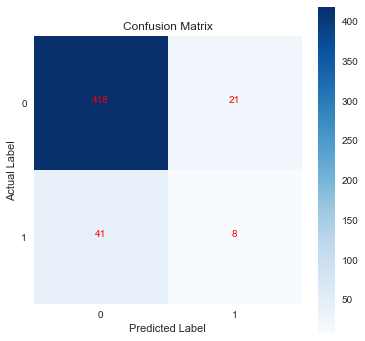

Precision                                   : 0.276
Recall                                      : 0.163
F1-Score                                    : 0.205

Precision Recall F1-Score Support Per Class : 
 (array([0.91067538, 0.27586207]), array([0.95216401, 0.16326531]), array([0.93095768, 0.20512821]), array([439,  49], dtype=int64))

Classification Report                       : 
              precision    recall  f1-score   support

       False       0.91      0.95      0.93       439
        True       0.28      0.16      0.21        49

    accuracy                           0.87       488
   macro avg       0.59      0.56      0.57       488
weighted avg       0.85      0.87      0.86       488



In [113]:
    volatility_shift_ad = VolatilityShiftAD(c=2.5, side="both", window=8)
    anomalies_vs = volatility_shift_ad.fit_detect(s)
    anomaly_plot(s, anomaly=anomalies_vs, anomaly_color="red",
                 title=f" Volatility Shift Ad Plot for site {site} on flow {flow} and device {device}"
    )
    
    Y_test = serie["anomaly"]
    Y_preds = anomalies_vs
    Y_preds=np.nan_to_num(Y_preds) #convierte NaN en zeros
    confusion_matrix_plot(Y_test, Y_preds)
    print_report(Y_test, Y_preds) 

    

min_cluster_detector está diseñado para detectar outliers en datasets multivariables. El outlier se da cuando la relación entre dos o más variables se dispara. En nuestro caso podriamos utlizarlo por ejemplo para detectar cuando la relación entre dos etapas del funnel.

Pero siguiendo con nuestro objetivo de detectar los outliers etiquetados notamos que el modelo no da resultados satisfactorio y tampoco cambia la métrica de precision y recall con diferentes clusters.


In [114]:
ClustersPar = [2,3,4,5,6,7,8,10,20]
Results_CD = pd.DataFrame(columns=['Parametro', 'Recall', 'Precision'])
Results_CD.set_index('Parametro')

for i in ClustersPar :
    min_cluster_detector = MinClusterDetector(KMeans(n_clusters=i))
    anomalies = min_cluster_detector.fit_detect(s.to_frame())
    Y_test = serie["anomaly"]
    Y_preds = anomalies_vs
    Y_preds=np.nan_to_num(Y_preds) #convierte NaN en zeros
    new_row = {'Parametro':"Clusters: "+ str(i), 'Recall':recall_score(Y_test, Y_preds), 'Precision':precision_score(Y_test, Y_preds)}
    Results_CD = Results_CD.append(new_row, ignore_index=True)

Results_CD.head(10)

,Parametro,Recall,Precision
0,Clusters: 2,0.163265,0.275862
1,Clusters: 3,0.163265,0.275862
2,Clusters: 4,0.163265,0.275862
3,Clusters: 5,0.163265,0.275862
4,Clusters: 6,0.163265,0.275862
5,Clusters: 7,0.163265,0.275862
6,Clusters: 8,0.163265,0.275862
7,Clusters: 10,0.163265,0.275862
8,Clusters: 20,0.163265,0.275862


In [115]:
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=10))
anomalies = min_cluster_detector.fit_detect(s.to_frame())
anomaly_plot(s, anomaly=anomalies, anomaly_color="red",
                 title=f" Min Cluster Detector for site {site} on flow {flow} and device {device}"
    )
    

